In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *


In [20]:
ytopics = []
y = 1990

run_id = 381

stat = RunStats.objects.get(pk=run_id)
dt_threshold=stat.dthreshold

[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for ar in ars:   
    ytopics = DocTopic.objects.filter(
        doc__PY__in=ar["years"],
        run_id=run_id,
        score__gt=dt_threshold
    ).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['AP'] = ar["name"]
    ndf['APn'] = ar["n"]
    if ar["name"]=="AR0":
        df = ndf
    else:
        df = df.append(ndf)

print(dt_threshold)       
df.head()

0.0029


,topic__title,topic_id,ttotal,AP,APn
0,"{temperatur, mean, thermal}",108475,0.026762,AR0,0
1,"{model, simul, predict}",108479,0.005813,AR0,0
2,"{record, holocen, cal}",108480,0.034392,AR0,0
3,"{water, irrig, resourc}",108483,0.004794,AR0,0
4,"{crop, yield, wheat}",108488,0.054146,AR0,0


In [48]:
df['x'] = df.apply(lambda x: x['APn']+(np.random.rand()-0.5)*0.5,axis=1)
df['change'] = df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)
df['pchange'] = (df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)) / df.groupby(['topic__title']).ttotal.shift(1) * 100
df.pchange=df['pchange']
#print(df[['APn','pchange']])
df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/x.max())

grouped = df.groupby('APn')

print(grouped.pchange.mean().reset_index())

#for name, group in grouped:
    #print(grouped.pchange.mean())

print(df[df.topic_id==115].head(125))

   APn      pchange
0    0          NaN
1    1  6996.186169
2    2  4080.649065
3    3   217.701357
4    4   156.432803
5    5   179.327801
6    6   -12.173304
Empty DataFrame
Columns: [topic__title, topic_id, ttotal, AP, APn, x, change, pchange, pchangen]
Index: []


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


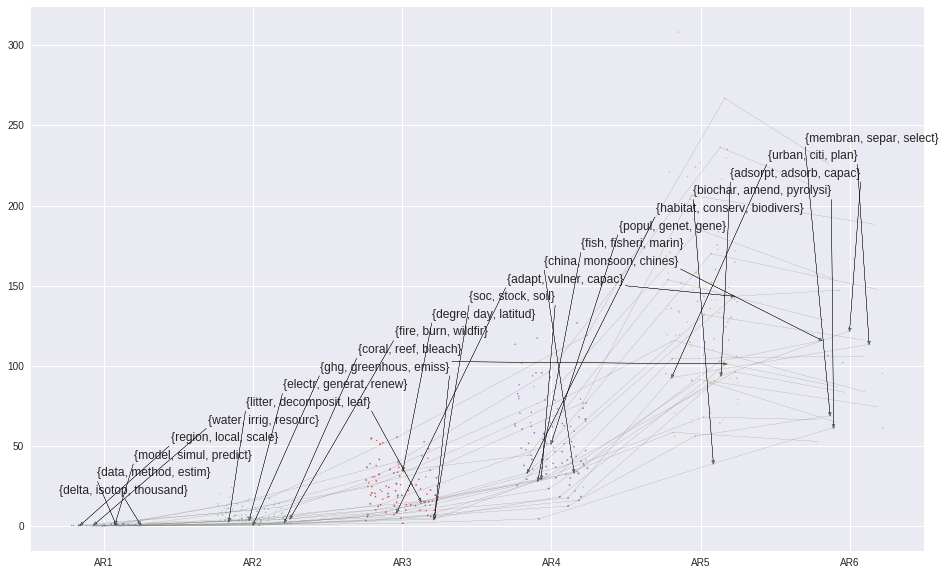

In [49]:
plt.rcParams["figure.figsize"] = [16,10]

topts = []

annotate = True

def f1(x):
    return '{0:.0f}%'.format(x)

ntopics = 5

for ar in ars:
    #break
    topar = df[df.AP==ar["name"]].sort_values(by='pchange', ascending=0).reset_index(drop=True)
    if ar["n"] > 0:
        # Write a table of top topics
        tab = topar[['topic__title','pchange']]
        tab['title'] = tab.apply(lambda x: x['topic__title'].replace('{','').replace('}',''),axis=1)
        tab = tab[['title','pchange']]  
        
        latex = tab.head(5).to_latex(float_format=f1,index=False)#,column_format='p{1.2cm}r')
        if ar["n"] > 5:
            with open("../tables/{}_top{}.tex".format(run_id,ar["name"]), "w") as f:
                f.write(latex)
 
            # Write a table of bottom topics
            latex = tab.tail(5).to_latex(float_format=f1,index=False)#,column_format='p{1.2cm}r')
            with open("../tables/{}_bottom{}.tex".format(run_id,ar["name"]), "w") as f:
                f.write(latex)

        
        #with open("../tables/top{}_tab.tex".format(ar["name"]), "w") as f:
        #    f.write(latex)
        plt.scatter(topar.x,topar.ttotal,s=topar.pchangen*5)
        i = 0
        for index, t in topar.head(ntopics).iterrows():
            
            if t.topic_id in topts:
                i = topts.index(t.topic_id)
                a = 0
            else:
                topts.append(t.topic_id)
                i = topts.index(t.topic_id)
                a = 1
            if annotate:
                text = plt.annotate(
                    t.topic__title,
                    #t.topic__title.replace(',','\n') + " (+{}%)".format(round(t.pchange*100)),
                    xy=(t.x,t.ttotal),
                    xytext=(0.7+i*0.25,20+i*11),
                    arrowprops=dict(facecolor='grey',width=0.01,headwidth=3,headlength=3,shrink=0.0001),
                    color = None
                    #size=0.5
                )
                text.set_alpha(a)
            else:
                plt.text(
                    t.x,
                    t.ttotal,
                    str(t.topic_id) #+ " (+{}%)".format(round(t.pchange*100))                
                )
        #for index, t in topar.tail().iterrows():
        #    plt.text(t.x,t.ttotal,t.topic__title)
        
tops = df[df.topic_id.isin(topts)]
tops = tops[tops.APn>0]

for name, group in tops.groupby(['topic_id']):
    plt.plot(group.x,group.ttotal,c="grey",lw=0.2)
    
plt.xticks([1,2,3,4,5,6],["AR1","AR2","AR3","AR4","AR5","AR6"])

wide = tops.pivot(index='topic__title',columns='AP',values='pchange').reset_index()
wide.columns.name = ''
wide= wide.reset_index(drop=True)

wider = tops[['topic_id','topic__title']].drop_duplicates().merge(wide,how="left").sort_values(by='topic_id')

i = 0
if not annotate:
    for index, t in wider.iterrows():
        i+=1
        plt.text(0.7,250-i*10,"{} : {}".format(t.topic_id,t.topic__title))
        
plt.savefig('../plots/hot_topics'+str(run_id)+'.png',bbox_inches='tight')             
plt.show()



In [50]:


df[df['topic__title']=="{biochar, amend, pyrolysi}"].head(7)

,topic__title,topic_id,ttotal,AP,APn,x,change,pchange,pchangen
8,"{biochar, amend, pyrolysi}",108565,0.020596,AR1,1,1.089515,NaN,NaN,NaN
19,"{biochar, amend, pyrolysi}",108565,0.449590,AR2,2,1.832701,0.428994,2082.942704,0.049528
29,"{biochar, amend, pyrolysi}",108565,1.816268,AR3,3,3.002660,1.366679,303.983577,0.465459
90,"{biochar, amend, pyrolysi}",108565,4.515320,AR4,4,3.915901,2.699052,148.604241,0.262158
90,"{biochar, amend, pyrolysi}",108565,39.070031,AR5,5,5.085911,34.554711,765.277104,1.000000
90,"{biochar, amend, pyrolysi}",108565,61.473404,AR6,6,5.891890,22.403373,57.341581,1.000000


/usr/local/lib/python3.4/dist-packages/pandas/core/generic.py:5135: RuntimeWarning: invalid value encountered in absolute
  return np.abs(self)


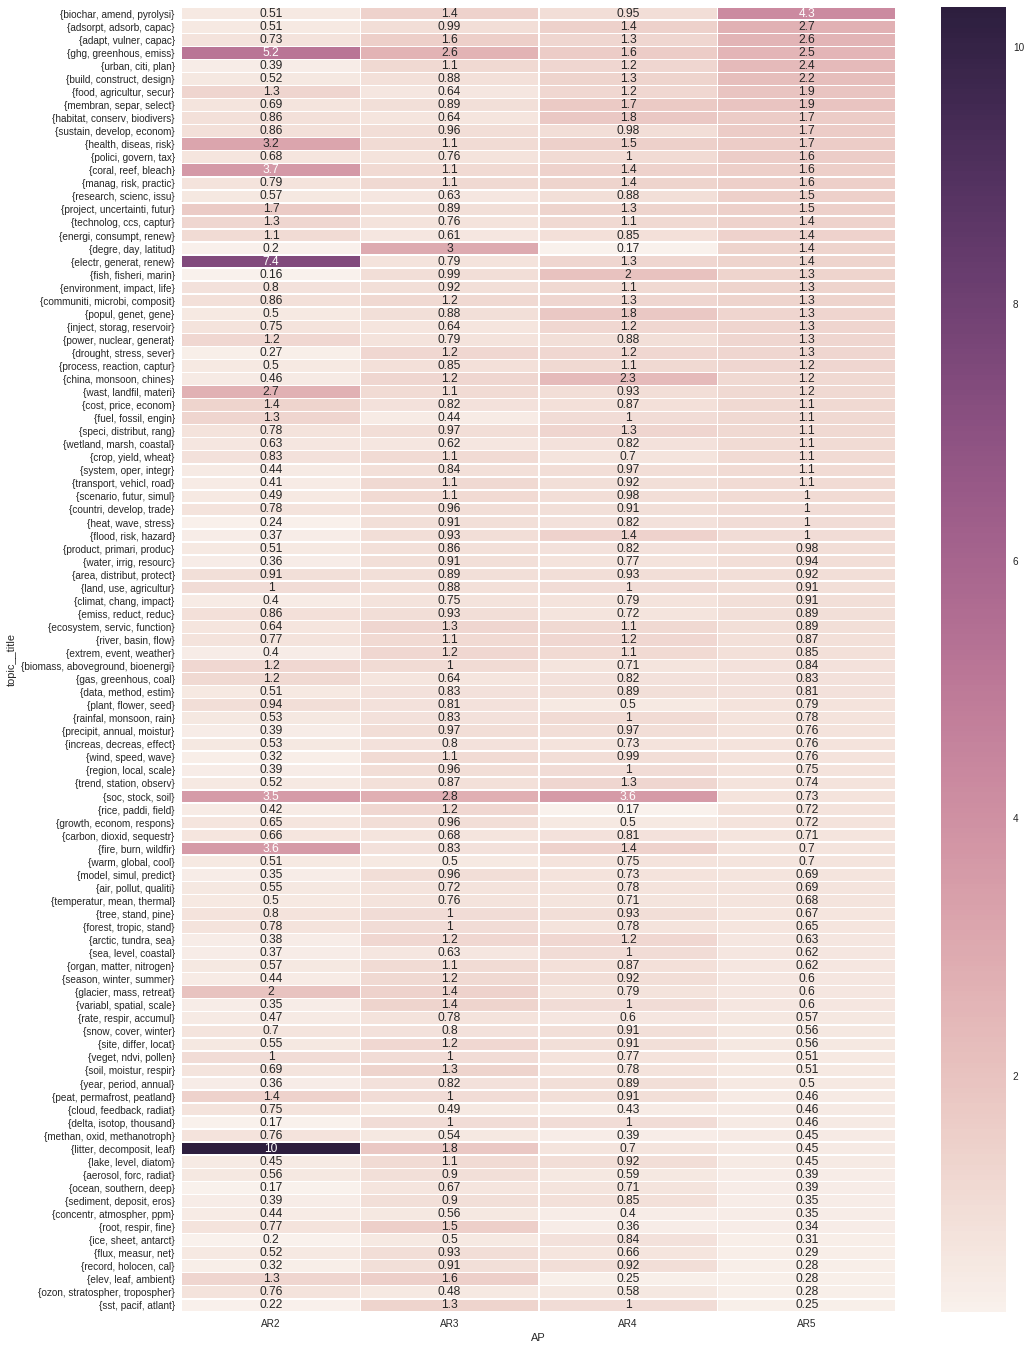

In [64]:
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = [16,24]

df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/abs(x.mean()))

ppdf = df[(df['APn'] > 1) & (df['APn'] < 6)].pivot('topic__title','AP','pchangen').fillna(0).sort_values('AR5',ascending=False)


sns.heatmap(ppdf, annot=True, linewidths=.5)

plt.show()

In [52]:
ppdf.head()

AP,AR2,AR3,AR4,AR5
topic__title,,,,
"{biochar, amend, pyrolysi}",0.510444,1.396333,0.949956,4.267476
"{adsorpt, adsorb, capac}",0.506923,0.991251,1.436991,2.681721
"{adapt, vulner, capac}",0.725283,1.580855,1.267075,2.596523
"{ghg, greenhous, emiss}",5.227105,2.633528,1.630486,2.520776
"{urban, citi, plan}",0.386397,1.118417,1.243367,2.381047


/usr/local/lib/python3.4/dist-packages/pandas/core/generic.py:5135: RuntimeWarning: invalid value encountered in absolute
  return np.abs(self)


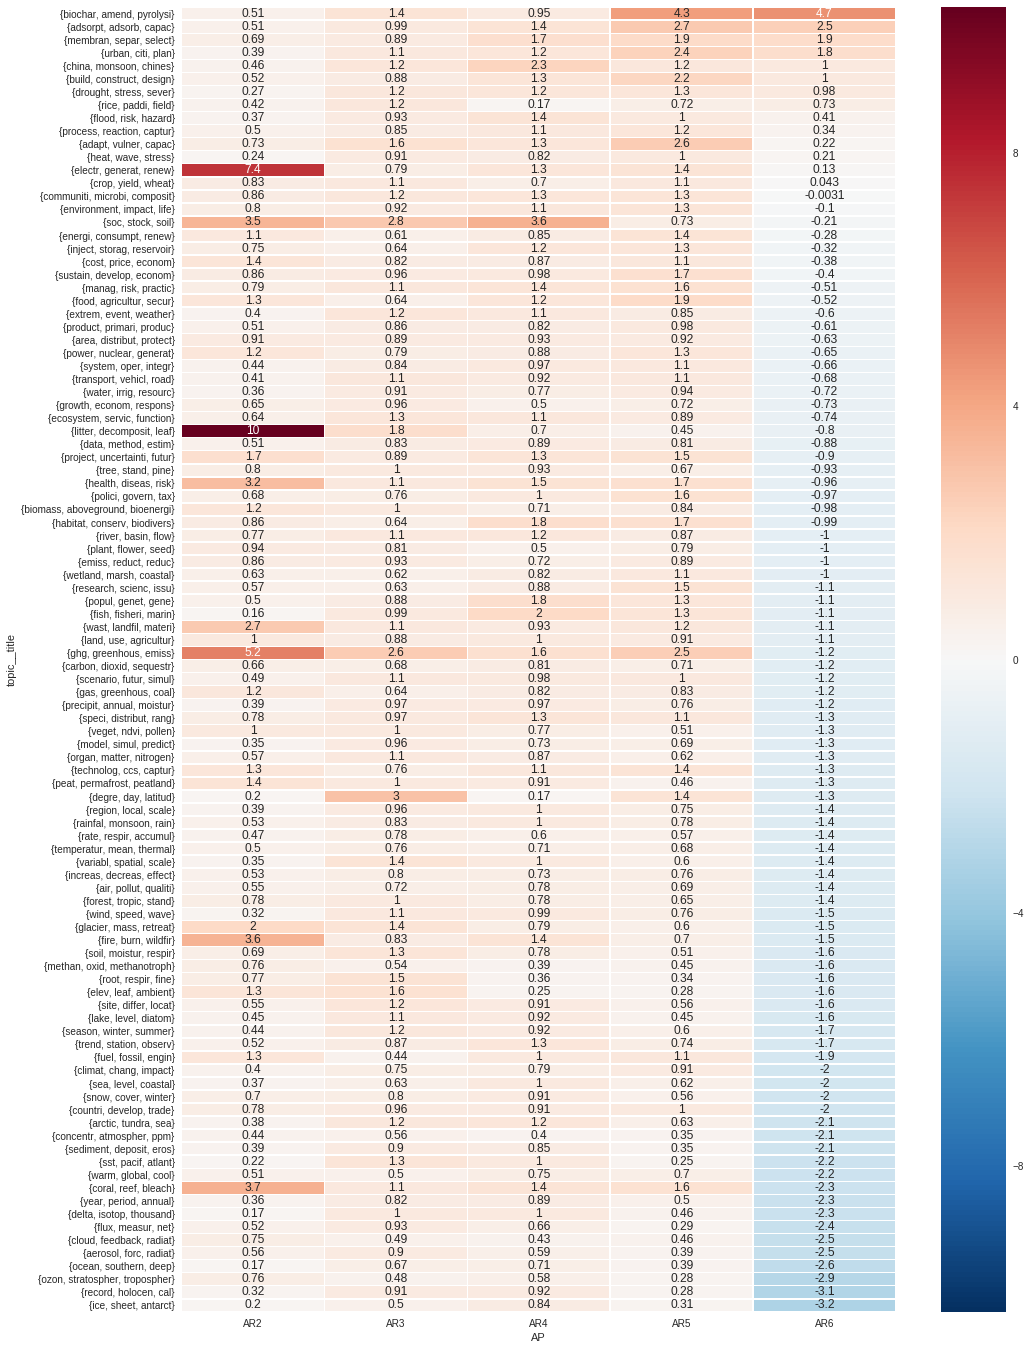

In [65]:
sns.set()
plt.rcParams["figure.figsize"] = [16,24]

df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/abs(x.mean()))
                                                               
ppdf = df[(df['APn'] > 1) & (df['APn'] < 7)].pivot('topic__title','AP','pchangen').fillna(0).sort_values('AR6',ascending=False)


sns.heatmap(ppdf, annot=True, linewidths=.5)

plt.show()

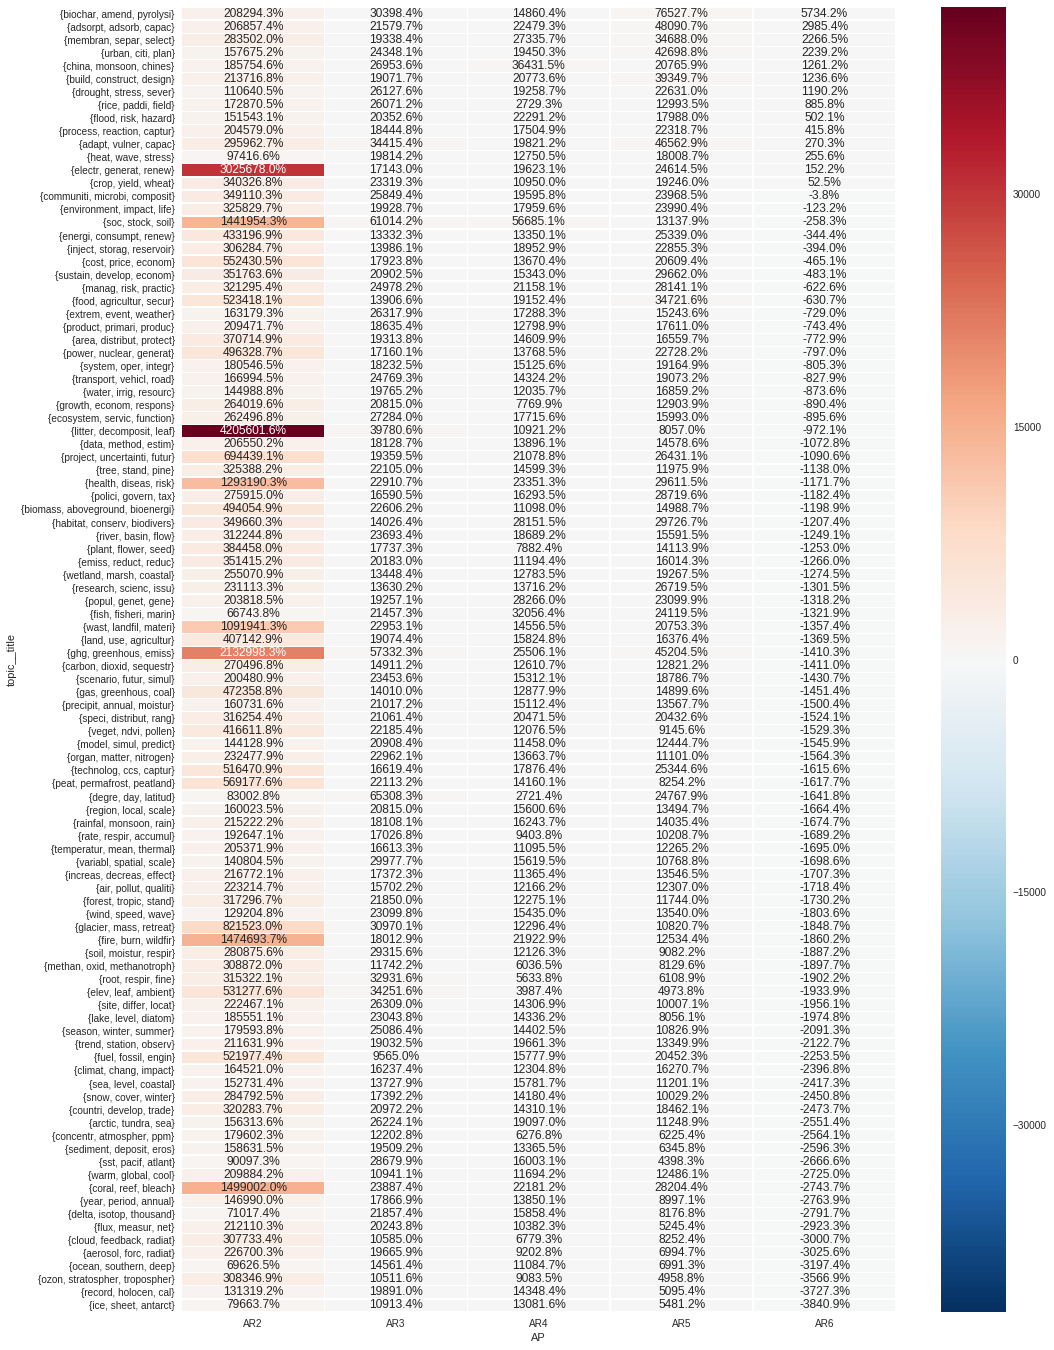

In [62]:
sns.set()
plt.rcParams["figure.figsize"] = [16,24]

df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/x.max())

ppdf = df[(df['APn'] > 1) & (df['APn'] < 7)].pivot('topic__title','AP','pchange').fillna(0).sort_values('AR6',ascending=False)


sns.heatmap(ppdf, annot=True, fmt=".1%", linewidths=.5)

plt.show()